<a href="https://colab.research.google.com/github/Xenon3050/cs900-1/blob/master/Exercises/day_1/Day1_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](https://i.imgur.com/a3uAqnb.png)

## **Goal:** Build a classification model to predict the rarity of pokemon cards (normal vs legendary).

# 1️⃣ Import Libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 2️⃣ Load the Data

In [42]:
# Download dataset
path = kagglehub.dataset_download("rounakbanik/pokemon")
print("Path:", path)

Using Colab cache for faster access to the 'pokemon' dataset.
Path: /kaggle/input/pokemon


In [43]:
# TODO: Load the CSV file into df_pokemon


pokemon_path = os.path.join(path, 'pokemon.csv')
df_pokemon = pd.read_csv(pokemon_path)

print(f"Shape: {df_pokemon.shape}")
df_pokemon.head()

Shape: (801, 41)


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


# 3️⃣ EDA

In [44]:
# TODO: Check the data info and missing values

missing_percentage = (df_pokemon.isnull().sum() / len(df_pokemon)) * 100
missing_data = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing_Percentage': missing_percentage.values
})
missing_data = missing_data[missing_data['Missing_Percentage'] > 0].sort_values('Missing_Percentage', ascending=False)

print("Missing Data Analysis:")
missing_data.head(10)

Missing Data Analysis:


,Column,Missing_Percentage
37,type2,47.940075
31,percentage_male,12.234707
27,height_m,2.496879
38,weight_kg,2.496879


In [45]:
# TODO: Check for target imbalance
# Hint: the target column is 'is_legendary'
df_pokemon.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

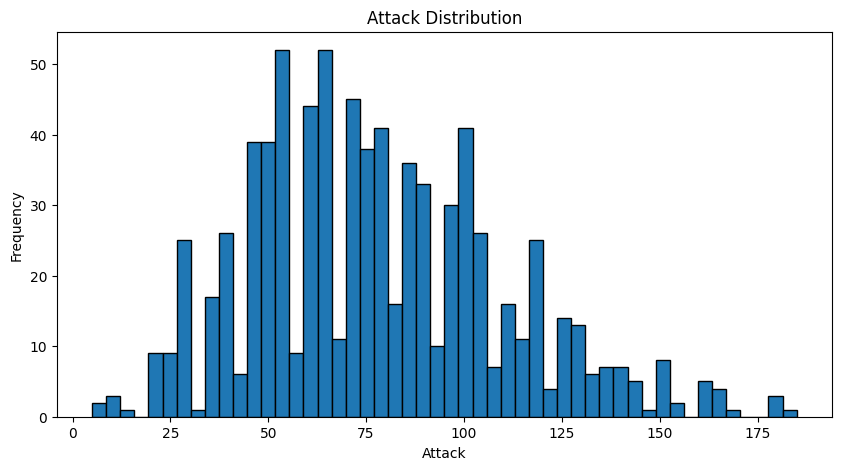

In [46]:
# TODO: Plot distribution of the stats (e.g., 'attack')
plt.figure(figsize=(10, 5))
plt.hist(df_pokemon['attack'].dropna(), bins=50, edgecolor='black')
plt.title('Attack Distribution')
plt.xlabel('Attack')
plt.ylabel('Frequency')
plt.show()

# 4️⃣ Data Cleaning

In [47]:
# Define stat columns
stat_cols = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

# TODO: Drop rows with missing values (not encluding 'type2')
df_clean = df_pokemon.copy()
df_clean = df_clean.dropna(subset=['percentage_male', 'height_m', 'weight_kg'])

In [48]:
# TODO: Fill missing type2
df_clean['type2'] = df_clean['type2'].fillna('none')

# 5️⃣ Encode Categorical Variables

In [49]:
# TODO: Encode type1 and type2 using LabelEncoder
le = LabelEncoder()
df_clean['type1'] = le.fit_transform(df_clean['type1'].astype(str))
df_clean['type2'] = le.fit_transform(df_clean['type2'].astype(str))

df_clean.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,9,14,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,9,14,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,9,14,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,6,12,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,6,12,19.0,1,0


# 6️⃣ Feature Engineering

In [51]:
# TODO: Create total_stats feature (sum of all stat columns)
df_clean['total_stats'] = df_clean[stat_cols].sum(axis=1)

# TODO: Create attack_defense_ratio feature
df_clean['attack_defense_ratio'] = df_clean['attack'] / df_clean['defense']

# 7️⃣ Prepare Data

In [52]:
# Define features and target
feature_cols = stat_cols + ['total_stats', 'attack_defense_ratio', 'type1', 'type2']

X = df_clean[feature_cols]
y = df_clean['is_legendary']

# TODO: Split data with stratification (test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (547, 10), Test: (137, 10)


In [53]:
# TODO: Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8️⃣ Train Model
### Challenge : Try to get > 97% F1 score

In [54]:
# TODO: Train RandomForestClassifier with class_weight='balanced'
model = RandomForestClassifier(class_weight='balanced', random_state=42)

model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# 9️⃣ Evaluate Model

In [55]:
# TODO: Make predictions and print accuracy
y_pred = model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Legendary']))

Accuracy: 0.9854
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       135
   Legendary       0.00      0.00      0.00         2

    accuracy                           0.99       137
   macro avg       0.49      0.50      0.50       137
weighted avg       0.97      0.99      0.98       137



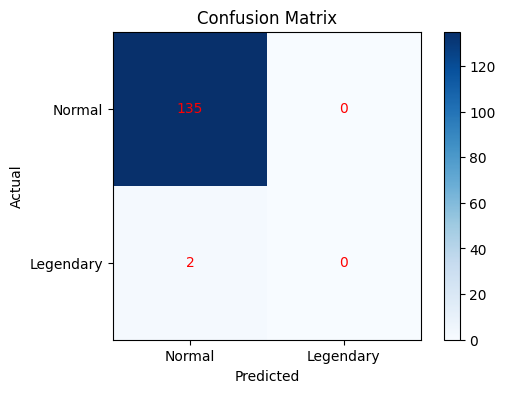

In [56]:
# TODO: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Legendary'])
plt.yticks([0, 1], ['Normal', 'Legendary'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()